# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

![Farmer in a field](farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will build multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

In [1]:
# All required libraries are imported here for you.
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Load the dataset
crops = pd.read_csv("./data/soil_measures.csv")

print(crops.shape)
crops.head()

(2200, 5)


,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


## Visualize class distributions

How does each predictor distribute itself within each crop? How do these distributions look relative to each other?

Intuitively, we'd expect the predictor that shows the most variation over the different crop types to be the most predictive.

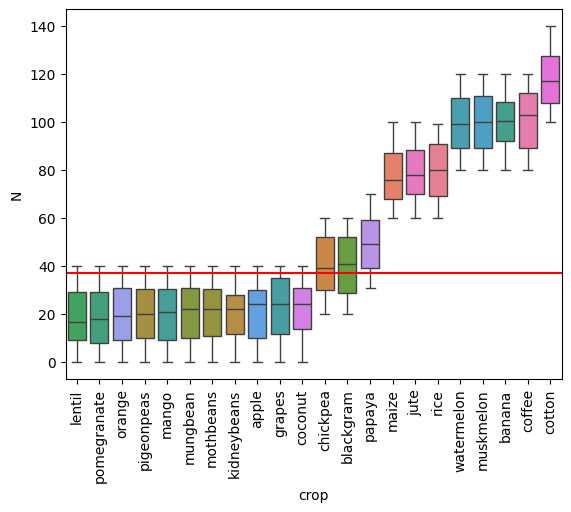

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_crop_pred(df, pred):
    """ Creates a boxplot of the distributions of a predictor (pred) across
    types of crop
    
    """
    # https://www.statology.org/seaborn-boxplot-order-x-axis/
    group_medians = df.groupby(['crop'])[pred].median().sort_values(ascending=True)
    
    pred_plot = sns.boxplot(data=df, x='crop', y=pred, hue="crop", order=group_medians.index)
    pred_plot.axhline(y = df[pred].median(), color='red')  # add grand median reference line
    plt.xticks(rotation=90)
    return pred_plot

# nitrogen
nitrogen_plot = plot_crop_pred(crops, 'N')

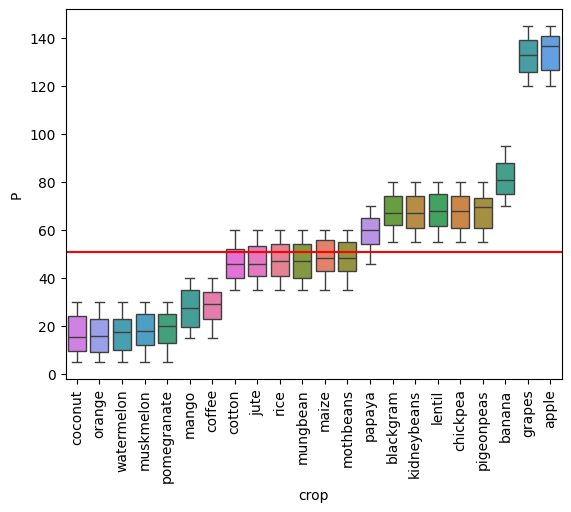

In [3]:
# phosphorous
phosphorous_plot = plot_crop_pred(crops, 'P')

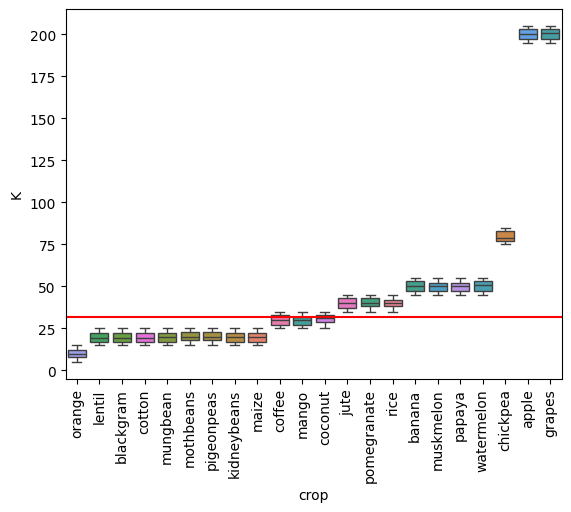

In [4]:
# potassium
potassium_plot = plot_crop_pred(crops, 'K')

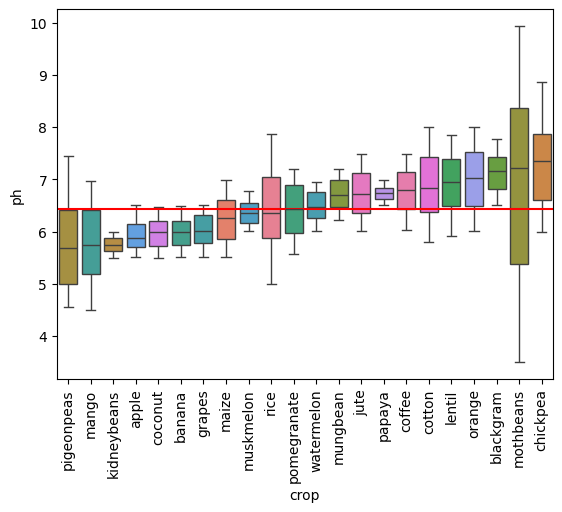

In [5]:
# pH
ph_plot = plot_crop_pred(crops, 'ph')

## Class balance

From the counts below, it looks like we have perfect balance between the classes.

In [6]:
# crops['crop'].value_counts()
crop_counts = crops['crop'].value_counts()
print(f"There are {len(crop_counts)} crop types \n")
print(crop_counts)

There are 22 crop types 

crop
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64


## Missing values

Doesn't look like there are any missing values.

In [7]:
print(crops.isna().sum().sort_values())

N       0
P       0
K       0
ph      0
crop    0
dtype: int64


## Encode the target column

The `crop` column is categorical and needs to be encoded.

In [8]:
crops['crop'] = crops['crop'].astype("category")
crops['crop_code'] = crops['crop'].cat.codes
print(crops.head(), '\n')
print(crops.tail(), '\n')

    N   P   K        ph  crop  crop_code
0  90  42  43  6.502985  rice         20
1  85  58  41  7.038096  rice         20
2  60  55  44  7.840207  rice         20
3  74  35  40  6.980401  rice         20
4  78  42  42  7.628473  rice         20 

        N   P   K        ph    crop  crop_code
2195  107  34  32  6.780064  coffee          5
2196   99  15  27  6.086922  coffee          5
2197  118  33  30  6.362608  coffee          5
2198  117  32  34  6.758793  coffee          5
2199  104  18  30  6.779833  coffee          5 



## Strategy

### Metric

The *negative log likelihood* or *cross-entropy* is used as the loss function for logistic regression in scikit, so this would be the most natural choice for the metric we use to evaluate model performance, but **accuracy** is more intuitive, so it will be used here.

### Workflow

1. Build a set of single parameter logistic regression models
2. Evaluate each set of models using 5-Fold CV and cross-entropy as the metric
3. Create a boxplot with each predictor on the x-axis and accuracy on the y-axis

The boxplot will allow us to see how each of the single-predictor models relative to each other. From this plot, the best model will be selected as the parameter with the most importance feature for predictive performance.

In [9]:
rand_state = 711  # for reproducibility
# predictor and target vectors
X = crops.drop(["crop", "crop_code"], axis="columns")
y = crops['crop_code']
# split to train and test sets - do BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_state)
X.head()

,N,P,K,ph
0,90,42,43,6.502985
1,85,58,41,7.038096
2,60,55,44,7.840207
3,74,35,40,6.980401
4,78,42,42,7.628473


In [10]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

cv_folds = 5      # specified above

# last 2 columns are the response and encoded response
predictors = list(crops.columns)[:-2]

accuracies = []
cross_ents = []

# build logistic regression models from each single predictor
for pred in predictors:
    # model = LogisticRegression(solver='lbfgs', max_iter=3000)
    model = LogisticRegression()
    scaler = StandardScaler()
    # scale the train and test predictor vectors
    X_train_scaled = scaler.fit_transform(X_train[pred].to_numpy().reshape(-1, 1))
    X_test_scaled = scaler.fit_transform(X_test[pred].to_numpy().reshape(-1, 1))
    
    X_train_pred = X_train_scaled #X_train[[pred]]
    model.fit(X_train_pred, y_train)
    # define model eval method, 5-fold cv x 3
    cv = RepeatedStratifiedKFold(n_splits=cv_folds, n_repeats=3, random_state=rand_state)
    # evaluate model
    scores_acc = cross_val_score(model, X_train_pred, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    scores_cross_ent = cross_val_score(model, X_train_pred, y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1)
    cv_score_acc = np.mean(scores_acc)
    cv_score_cross_ent = np.mean(scores_cross_ent)
    accuracies.append(cv_score_acc)
    cross_ents.append(cv_score_cross_ent)
    print(f"For the {pred} predictor, mean CV model accuracy = {round(cv_score_acc, 5)}, random accuracy = {round(1/len(crop_counts), 5)}")
    print(f"For the {pred} predictor, mean CV model cross ent = {round(cv_score_cross_ent, 5)}, random accuracy = {round(1/len(crop_counts), 5)} \n")

print('**************************************************')

# evaluate best predictor
best_accuracy = max(accuracies)
best_acc_index = accuracies.index(best_accuracy)
best_acc_pred = predictors[best_acc_index]
best_cross_ent = max(cross_ents)
best_cross_end_index = cross_ents.index(best_cross_ent)
best_cross_ent_pred = predictors[best_cross_end_index]

print(f"best predictor by accuracy is {best_acc_pred} with accuracy of {best_accuracy}")
print(f"best predictor by cross entropy is {best_cross_ent_pred} with cross entropy of {best_cross_ent}")

For the N predictor, mean CV model accuracy = 0.15778, random accuracy = 0.04545
For the N predictor, mean CV model cross ent = -2.28616, random accuracy = 0.04545 

For the P predictor, mean CV model accuracy = 0.21414, random accuracy = 0.04545
For the P predictor, mean CV model cross ent = -2.08917, random accuracy = 0.04545 

For the K predictor, mean CV model accuracy = 0.26586, random accuracy = 0.04545
For the K predictor, mean CV model cross ent = -2.20939, random accuracy = 0.04545 

For the ph predictor, mean CV model accuracy = 0.10909, random accuracy = 0.04545
For the ph predictor, mean CV model cross ent = -2.86628, random accuracy = 0.04545 

**************************************************
best predictor by accuracy is K with accuracy of 0.2658585858585859
best predictor by cross entropy is P with cross entropy of -2.0891681007068894


In [11]:
best_predictive_feature = {best_acc_pred: best_accuracy}
print(best_predictive_feature)

{'K': 0.2658585858585859}
